<h1><center>Backtesting financial strategies</center></h1>

## Package import

In [329]:
%load_ext autoreload
%autoreload 2

import wrds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime
from data_extraction import *
from mean_reversion import *
from mean_variance import *
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import bahc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

### Stock prices

In [196]:
BEGINNING=datetime.date(2004,1,1)
END=datetime.date(2009,1,1)

In [197]:
# Uncomment this to run the extraction script, since it's time consuming, we have saved a copy "stocks.csv"
# df=extract_trade_df()

In [198]:
df=pd.read_csv("stocks.csv")

In [199]:
# Set datetime as index
df.index=df.xltime.apply(lambda x : datetime.datetime.strptime(str(x)[:-6],"%Y-%m-%d %H:%M:%S"))
df.drop(columns="xltime",inplace=True)

In [200]:
# Only include trading hours
start_time = "09:30:00"
end_time = "16:00:00"
df = df.between_time(start_time, end_time)

In [201]:
# Fill the Nans
df.fillna(method="ffill",inplace=True)

In [202]:
# Check Nans at the start
df.isna().sum().value_counts()

0         40
1         18
2         10
3          5
4          3
5          2
170867     1
291686     1
606053     1
111436     1
143499     1
8          1
341767     1
dtype: int64

In [203]:
df_columns_missing = df.columns[df.isna().sum() > 10].values
df_columns_missing

array(['DVN', 'PM', 'V', 'MS', 'NOV', 'MA'], dtype=object)

These stocks were introduced after 2004 and contain a lot of Nans, best thing is to remove them

In [204]:
# Drop and backfill the remaining
df.drop(df_columns_missing, inplace=True, axis=1)
df.bfill(inplace = True)
df.head()

,DOW,PEP,CVS,UNH,CL,DD,EXC,SLB,FDX,AA,...,JPM,BAC,MRK,XRX,TGT,XOM,PFE,UPS,AXP,APA
xltime,,,,,,,,,,,,,,,,,,,,,
2004-01-02 09:30:00,41.57,46.94,36.29,59.05,49.95,45.98,66.65,54.72,67.70,38.00,...,36.56,79.75,46.73,13.62,38.45,41.02,35.43,73.20,48.43,81.25
2004-01-02 09:31:00,41.57,46.95,36.27,59.05,49.96,45.98,66.68,54.72,67.70,38.00,...,36.58,79.75,46.73,13.62,38.50,41.03,35.40,73.16,48.43,81.40
2004-01-02 09:32:00,41.56,46.95,36.29,59.05,50.00,45.98,66.73,54.73,67.70,38.05,...,36.58,79.76,46.73,13.63,38.50,41.05,35.44,73.37,48.39,81.40
2004-01-02 09:33:00,41.55,47.00,36.16,59.05,50.03,46.09,66.85,54.73,67.54,38.08,...,36.69,79.87,46.73,13.64,38.57,41.11,35.44,73.45,48.46,81.40
2004-01-02 09:34:00,41.61,47.06,36.32,59.05,50.08,46.10,66.75,54.67,67.86,38.10,...,36.73,79.93,46.73,13.71,38.62,41.12,35.43,73.60,48.50,81.33


In [205]:
' '.join(str(df.columns)[7:-24].replace("'","").replace(",","").split()) 

'DOW PEP CVS UNH CL DD EXC SLB FDX AA NKE JNJ VZ BAX GD WMT RTN WY LMT BHI WMB MCD MDT KFT BMY ETR GE COF OXY ALL BA T ABT F HNZ FCX HAL UTX KO LOW EMR MMM SO WFC USB HPQ IBM COP UNP C S TWX EMC MET GS PG DIS CAT WAG HD BK HON CVX MO NSC MON TXN AEP AVP JPM BAC MRK XRX TGT XOM PFE UPS AXP APA'

In [206]:
# resample by daily closing price
df_day_opening = df.resample('d').first().dropna()

#### Splits

We check for splits, that is stocks where the stock price has descrease by more than a half during the night.

In [207]:
stock_splitted = df_day_opening.columns.values[(pd.DataFrame(df_day_opening[:-1].values / df_day_opening[1:].values) > 1.9).sum() > 0]
stock_splitted

array(['CVS', 'UNH', 'EXC', 'SLB', 'NKE', 'GD', 'OXY', 'HAL', 'UTX',
       'LOW', 'EMR', 'WFC', 'COP', 'UNP', 'PG', 'CAT', 'CVX', 'MO', 'MON',
       'AVP', 'BAC', 'APA'], dtype=object)

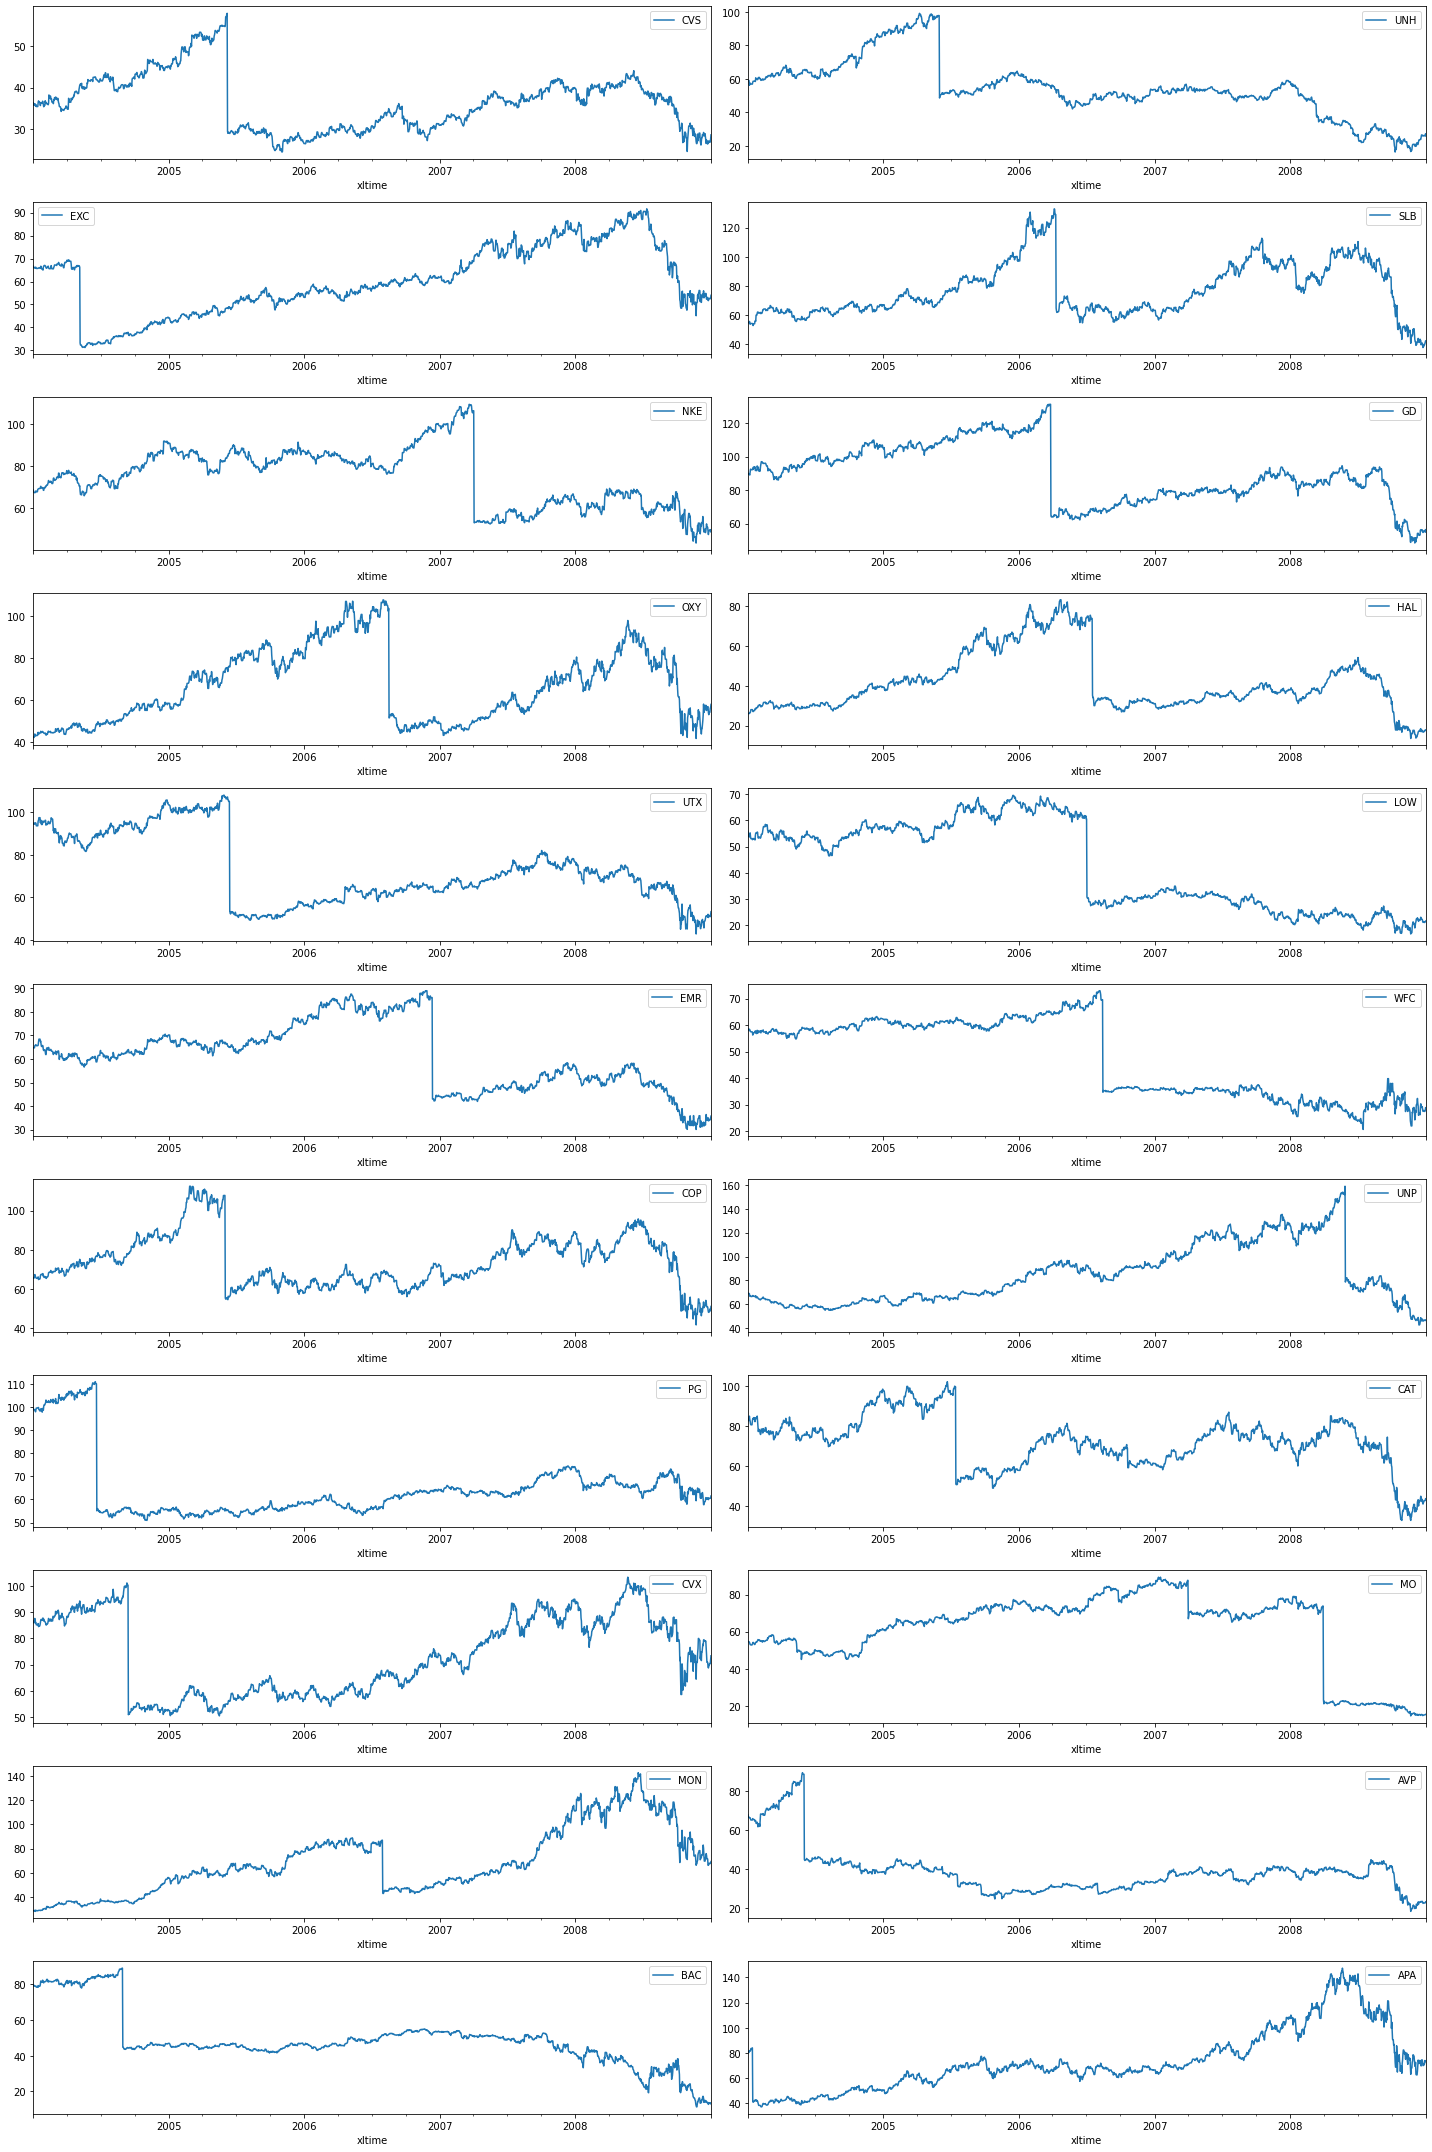

In [208]:
fig, axs = plt.subplots(figsize = (20,30), nrows = 11, ncols = 2)
axs = axs.flatten()
for i,stock in enumerate(stock_splitted):
    df_day_opening[stock].plot(label=stock, legend=True, ax = axs[i])

plt.tight_layout()
plt.savefig('split.png', dpi=300)
plt.show()

In [209]:
#we dtrop MO : Altria because the change is not done due to a stock split but rather a split with PMI 
df.drop('MO', inplace=True, axis=1)
indices = np.where(stock_splitted=='MO')
stock_splitted = np.delete(stock_splitted, indices)

#we drop S : Sprint marged with Nextel
df.drop('S', inplace=True, axis=1)

In [210]:
dict_split = {'CVS' : '2005-06-08', 'UNH' : '2005-06-01', 'EXC' : '2004-05-07', 'SLB' : '2006-04-11',
              'NKE' : '2007-04-03', 'GD' : '2006-03-28', 'OXY' : '2006-08-17','HAL' : '2006-07-18',
              'UTX' : '2005-06-14', 'LOW' : '2006-07-03', 'EMR' : '2006-12-12', 'WFC' : '2006-08-15',
              'COP' : '2005-06-02', 'UNP' :  '2008-05-29', 'PG' : '2004-06-21', 'CAT' : '2005-07-15',
              'WFC' : '2006-08-15', 'CVX' : '2004-09-14', 'MON':  '2006-07-31', 'AVP' : '2004-06-02',
              'BAC' : '2004-08-30', 'APA' : '2004-01-15'}

In [211]:
for (stock, time) in dict_split.items():
    split_time = datetime.datetime.strptime(time, "%Y-%m-%d")
    df.loc[df.index < split_time, stock]= df.loc[df.index < split_time, stock] / 2 

In [212]:
df_day_opening = df.resample('d').first().dropna()
df_day_closing = df.resample('d').last().dropna()

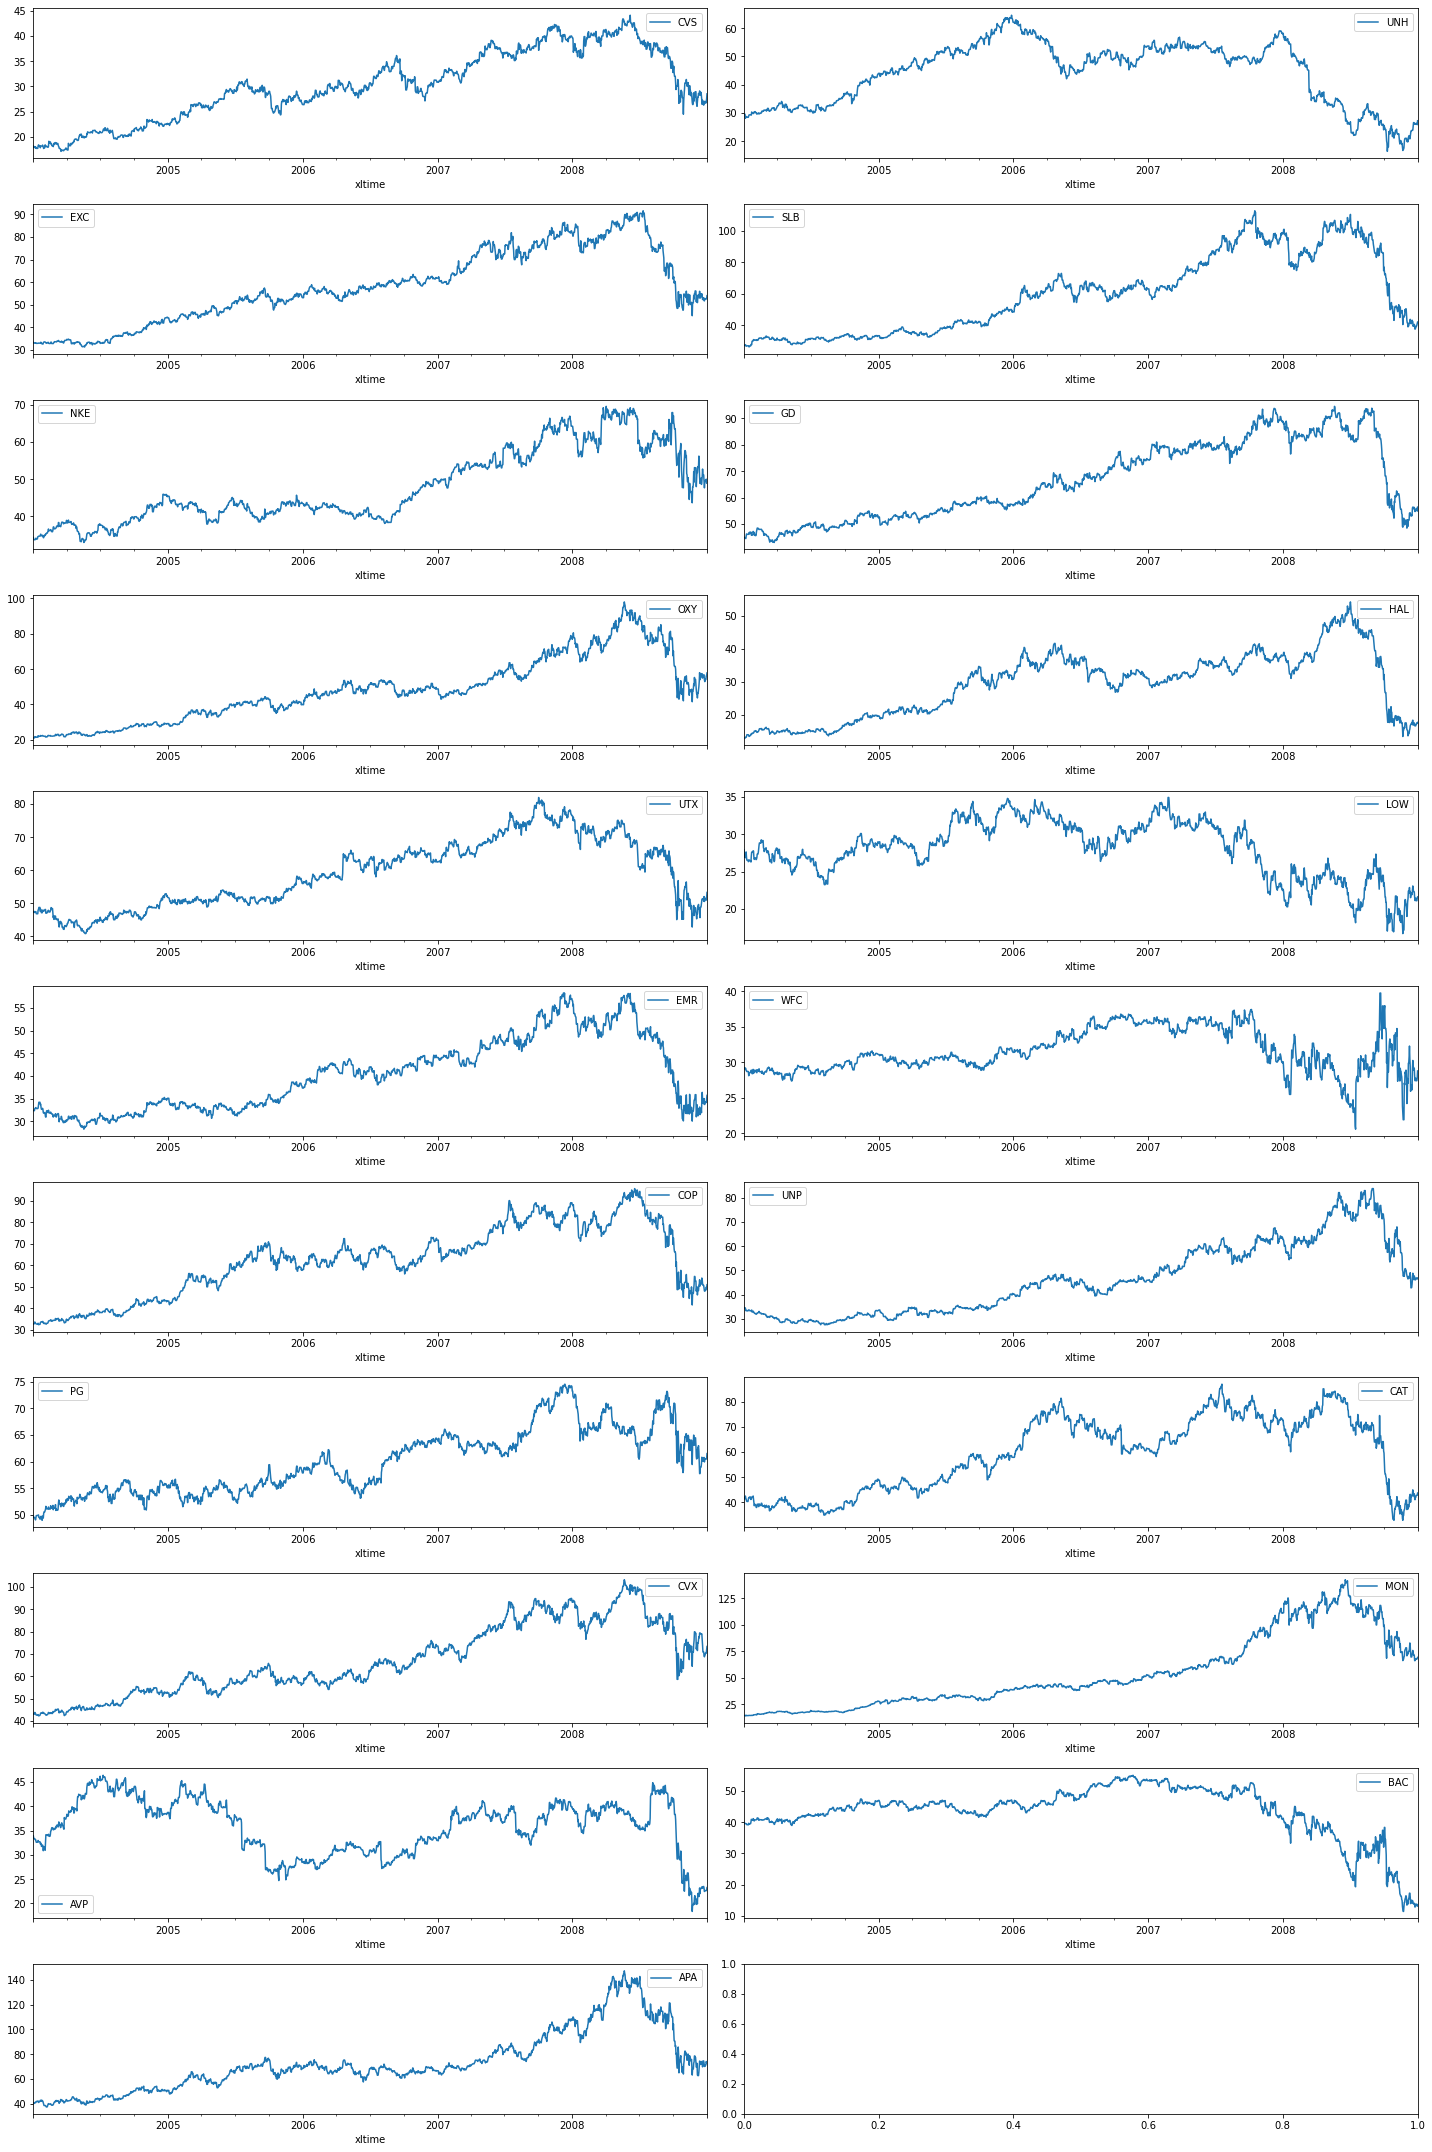

In [213]:
fig, axs = plt.subplots(figsize = (20,30), nrows = 11, ncols = 2)
axs = axs.flatten()
for i,stock in enumerate(stock_splitted):
    df_day_opening[stock].plot(label=stock, legend=True, ax = axs[i])
    
plt.tight_layout()
plt.show()

(731581.0, 733408.0)

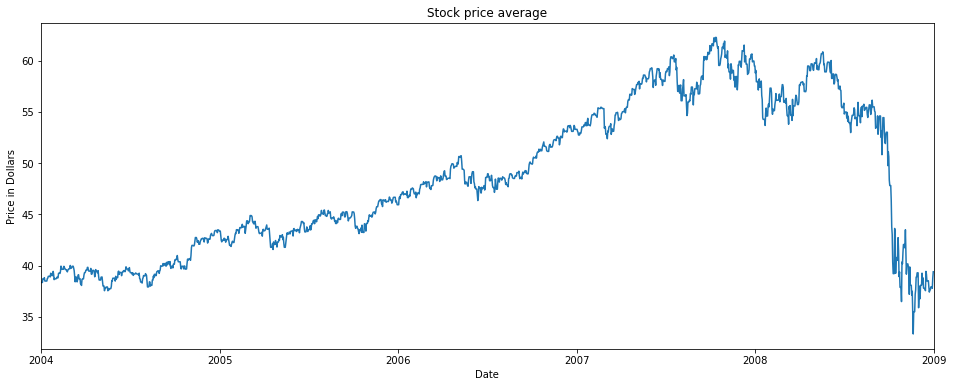

In [214]:
averge_prices=df_day_closing.mean(axis=1)


fig ,ax = plt.subplots(figsize=(16,6))
plt.plot(averge_prices)
ax.set_title("Stock price average")
ax.set_ylabel("Price in Dollars")
ax.set_xlabel("Date")
ax.set_xlim(left=datetime.date(2004,1,1),right=datetime.date(2009,1,1))

### WRDS

In [215]:
db = wrds.Connection(wrds_username='hmha')
db.create_pgpass_file()

ERROR:sqlalchemy.pool.impl.QueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\hm.haitham\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\hm.haitham\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\hm.haitham\anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Loading library list...
Done
Enter your WRDS username [hm.haitham]:hmha
Enter your password:········


In [216]:
# get the companies permco
company_info=db.raw_sql("select  permco , ticker, namedt, nameenddt,comnam "
           "from crsp.stocknames "
             "where namedt<'2009-01-01' and nameenddt>'2009-01-01'")

In [217]:
company_info

,permco,ticker,namedt,nameenddt,comnam
0,7953.0,EWST,2008-02-05,2009-08-03,ENERGY WEST INC
1,7954.0,BTFG,2002-05-15,2013-02-15,BANCTRUST FINANCIAL GROUP INC
2,7975.0,AEPI,1986-01-30,2017-01-20,A E P INDUSTRIES INC
3,7976.0,JJSF,1986-02-04,2019-12-31,J & J SNACK FOODS CORP
4,7978.0,DGC,2007-10-31,2009-08-16,D G S E COMPANIES INC
...,...,...,...,...,...
6860,53112.0,FCTY,2008-12-18,2016-06-30,1ST CENTURY BANKSHARES INC
6861,56283.0,WXCO,2008-12-05,2011-01-02,W H X CORP
6862,7378.0,VIDE,1985-01-15,2015-04-29,VIDEO DISPLAY CORP
6863,39147.0,JNK,2008-11-07,2019-05-05,SPDR SERIES TRUST


In [218]:
selected_tickers=df.columns.values
selected_tickers

array(['DOW', 'PEP', 'CVS', 'UNH', 'CL', 'DD', 'EXC', 'SLB', 'FDX', 'AA',
       'NKE', 'JNJ', 'VZ', 'BAX', 'GD', 'WMT', 'RTN', 'WY', 'LMT', 'BHI',
       'WMB', 'MCD', 'MDT', 'KFT', 'BMY', 'ETR', 'GE', 'COF', 'OXY',
       'ALL', 'BA', 'T', 'ABT', 'F', 'HNZ', 'FCX', 'HAL', 'UTX', 'KO',
       'LOW', 'EMR', 'MMM', 'SO', 'WFC', 'USB', 'HPQ', 'IBM', 'COP',
       'UNP', 'C', 'TWX', 'EMC', 'MET', 'GS', 'PG', 'DIS', 'CAT', 'WAG',
       'HD', 'BK', 'HON', 'CVX', 'NSC', 'MON', 'TXN', 'AEP', 'AVP', 'JPM',
       'BAC', 'MRK', 'XRX', 'TGT', 'XOM', 'PFE', 'UPS', 'AXP', 'APA'],
      dtype=object)

In [219]:
company_info=company_info[[t in selected_tickers for t in company_info.ticker]].drop_duplicates()
company_info

,permco,ticker,namedt,nameenddt,comnam
18,22168.0,HON,1999-12-02,2019-12-31,HONEYWELL INTERNATIONAL INC
19,8093.0,EMC,1988-03-22,2016-09-06,E M C CORP MA
134,20468.0,KO,1968-01-02,2019-12-31,COCA COLA CO
181,20606.0,DD,1968-01-02,2017-08-31,DU PONT E I DE NEMOURS & CO
202,20678.0,XOM,1999-12-01,2019-12-31,EXXON MOBIL CORP
...,...,...,...,...,...
3686,36383.0,UPS,1999-11-10,2019-12-31,UNITED PARCEL SERVICE INC
3774,37138.0,MET,2000-04-05,2019-12-31,METLIFE INC
3983,40148.0,MON,2000-10-18,2018-06-06,MONSANTO CO NEW
4106,41680.0,KFT,2001-06-13,2012-06-25,KRAFT FOODS INC


In [220]:
# Check if we have all we need
sorted(company_info.ticker.unique())==sorted(selected_tickers)

True

In [221]:
permcos=company_info.permco.unique()

In [222]:
shares=db.raw_sql("select date,permco,shrout "
           "from crsp.dsf "
           "where permco in {0} "
           "and date>='2004-01-01'"
            "and date<='2008-12-31'".format(tuple(permcos)))

In [223]:
shares.permco=shares.permco.astype(int)
shares.shrout=shares.shrout.astype(int)
company_info.permco=company_info.permco.astype(int)

# create the mapping
permco_to_ticker=pd.Series(company_info.ticker.values,index=company_info.permco).to_dict()
shares["ticker"]=shares.permco.apply(lambda x : permco_to_ticker[x])

In [224]:
# Check for negative prices
df_day_closing[df_day_closing<0].sum().sum()

0.0

#### Market Cap

In [225]:
# Create a shares df that matches the prices df
shares.date=pd.to_datetime(shares.date)
shares=shares.pivot(index="date",columns="ticker",values="shrout").reindex(df_day_closing.index,method="ffill")
shares=shares[df_day_closing.columns.values]

In [226]:
#compute market cap
market_cap=shares*df_day_closing
market_cap["Total"]=market_cap.sum(axis=1)
market_cap=market_cap.apply(lambda x : x/market_cap["Total"].values)
market_cap.drop(columns=["Total"],inplace=True)
market_cap.head()

ticker,DOW,PEP,CVS,UNH,CL,DD,EXC,SLB,FDX,AA,...,JPM,BAC,MRK,XRX,TGT,XOM,PFE,UPS,AXP,APA
xltime,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.009309,0.019621,0.001736,0.004258,0.006556,0.011159,0.002655,0.003933,0.004981,0.007983,...,0.018385,0.014454,0.025731,0.002641,0.008458,0.066048,0.066646,0.009904,0.015109,0.001602
2004-01-03,0.009309,0.019621,0.001736,0.004258,0.006556,0.011159,0.002655,0.003933,0.004981,0.007983,...,0.018385,0.014454,0.025731,0.002641,0.008458,0.066048,0.066646,0.009904,0.015109,0.001602
2004-01-04,0.009309,0.019621,0.001736,0.004258,0.006556,0.011159,0.002655,0.003933,0.004981,0.007983,...,0.018385,0.014454,0.025731,0.002641,0.008458,0.066048,0.066646,0.009904,0.015109,0.001602
2004-01-05,0.009366,0.019720,0.001729,0.004006,0.006537,0.011147,0.002629,0.003950,0.004932,0.008142,...,0.018144,0.014324,0.025975,0.002662,0.008287,0.066711,0.067718,0.009819,0.015073,0.001606
2004-01-06,0.009254,0.019831,0.001727,0.004044,0.006574,0.011047,0.002614,0.003905,0.004897,0.008080,...,0.018560,0.014284,0.025799,0.002701,0.008535,0.066274,0.067625,0.009752,0.015067,0.001611


In [227]:
returns=df_day_closing.pct_change()
returns.fillna(0,inplace=True)
returns.head()

,DOW,PEP,CVS,UNH,CL,DD,EXC,SLB,FDX,AA,...,JPM,BAC,MRK,XRX,TGT,XOM,PFE,UPS,AXP,APA
xltime,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-01-05,0.018000,0.017004,0.007837,-0.047958,0.008869,0.010767,0.001970,0.016294,0.001916,0.032000,...,-0.001365,0.002782,0.021485,0.019912,-0.008484,0.022033,0.028169,0.003123,0.009424,0.014303
2004-01-06,-0.010514,0.006984,0.000278,0.010858,0.006993,-0.007609,-0.004083,-0.010088,-0.005736,-0.006202,...,0.024330,-0.001387,-0.005414,0.015907,0.031283,-0.005179,0.000000,-0.005414,0.001037,0.004414


## Trading Strategies

### Hold the market

(731581.0, 733408.0)

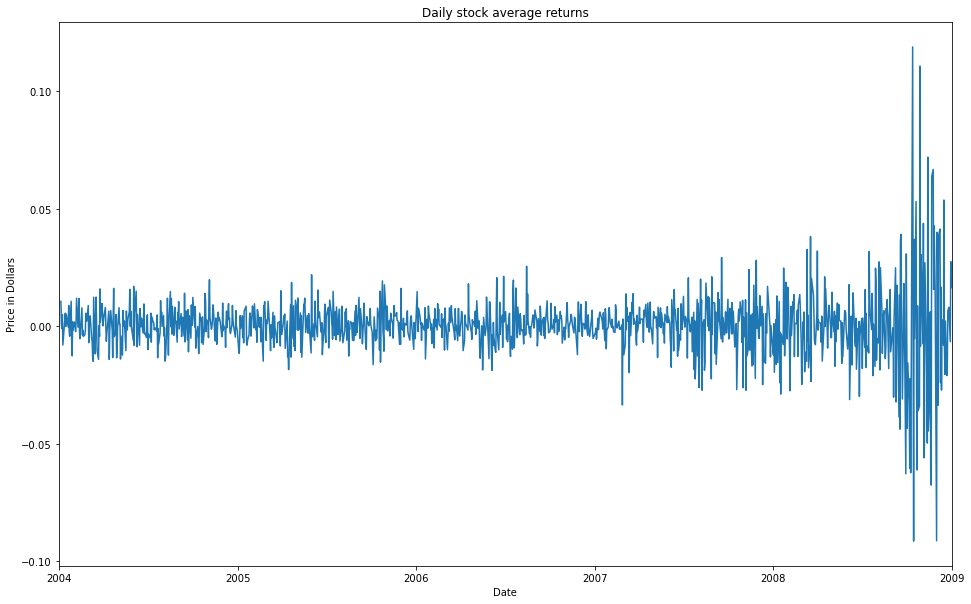

In [258]:
average_returns=returns.mean(axis=1)

fig ,ax = plt.subplots(figsize=(16,10))
plt.plot(average_returns)
ax.set_title("Daily stock average returns")
ax.set_ylabel("Price in Dollars")
ax.set_xlabel("Date")
ax.set_xlim(left=datetime.date(2004,1,1),right=datetime.date(2009,1,1))

In [259]:
portfolios=pd.DataFrame({"average":average_returns})
portfolios

,average
xltime,
2004-01-05,0.010592
2004-01-06,0.000872
2004-01-07,-0.001027
2004-01-08,0.004896
2004-01-09,-0.008006
...,...
2008-12-24,0.006507
2008-12-26,0.008024
2008-12-29,-0.006581


### Value Weighted Portfolio

In [260]:
portfolios["Value Weighted"]=(returns*market_cap).sum(axis=1)

### Mean Variance Portfolio

In [261]:
# Remove rows with null values to reduce colinearity
returns = returns[(returns.T != 0).any()]

#### Unfiltered covariance

Text(105.0, 0.5, 'Stocks')

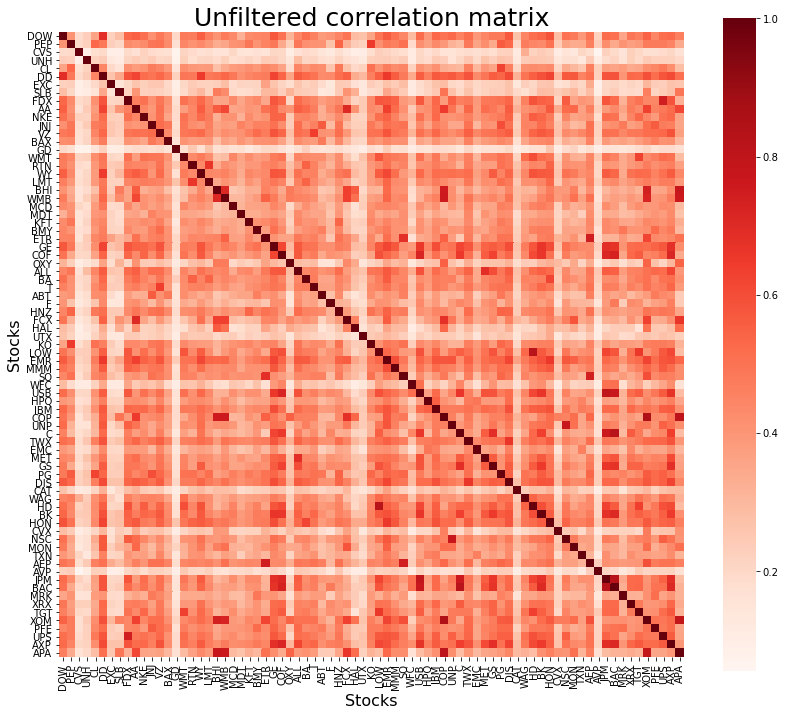

In [262]:
correlation=returns.corr()
fig ,ax = plt.subplots(figsize=(14,12))
sns.heatmap(correlation,xticklabels=True, yticklabels=True,square=True,cmap="Reds")
plt.title("Unfiltered correlation matrix",fontsize=25)
plt.xlabel("Stocks",fontsize=16)
plt.ylabel("Stocks",fontsize=16)

Text(105.0, 0.5, 'Stocks')

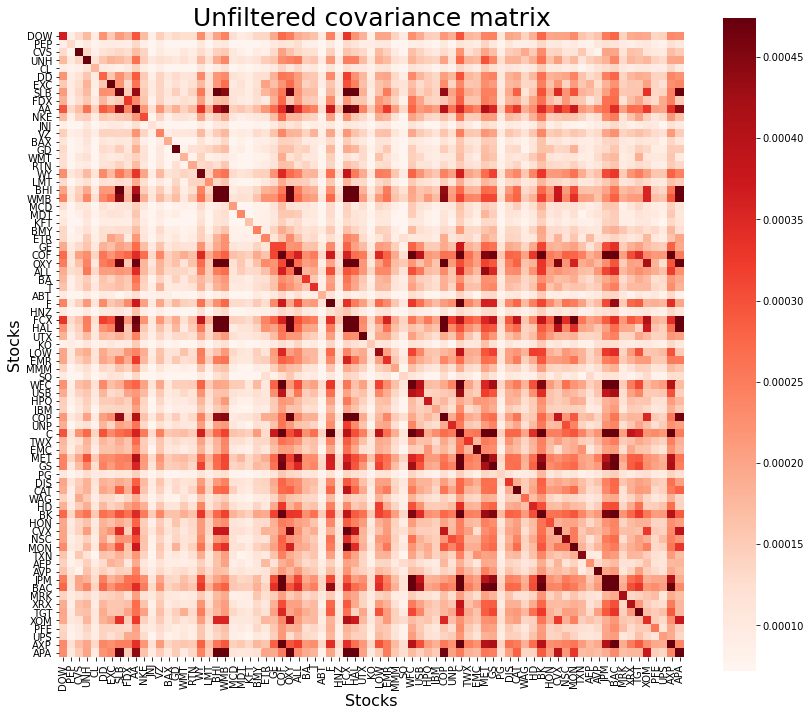

In [263]:
covariance=returns.cov()
fig ,ax = plt.subplots(figsize=(14,12))
sns.heatmap(covariance,xticklabels=True, yticklabels=True,robust=True,square=True,cmap="Reds")
plt.title("Unfiltered covariance matrix",fontsize=25)
plt.xlabel("Stocks",fontsize=16)
plt.ylabel("Stocks",fontsize=16)

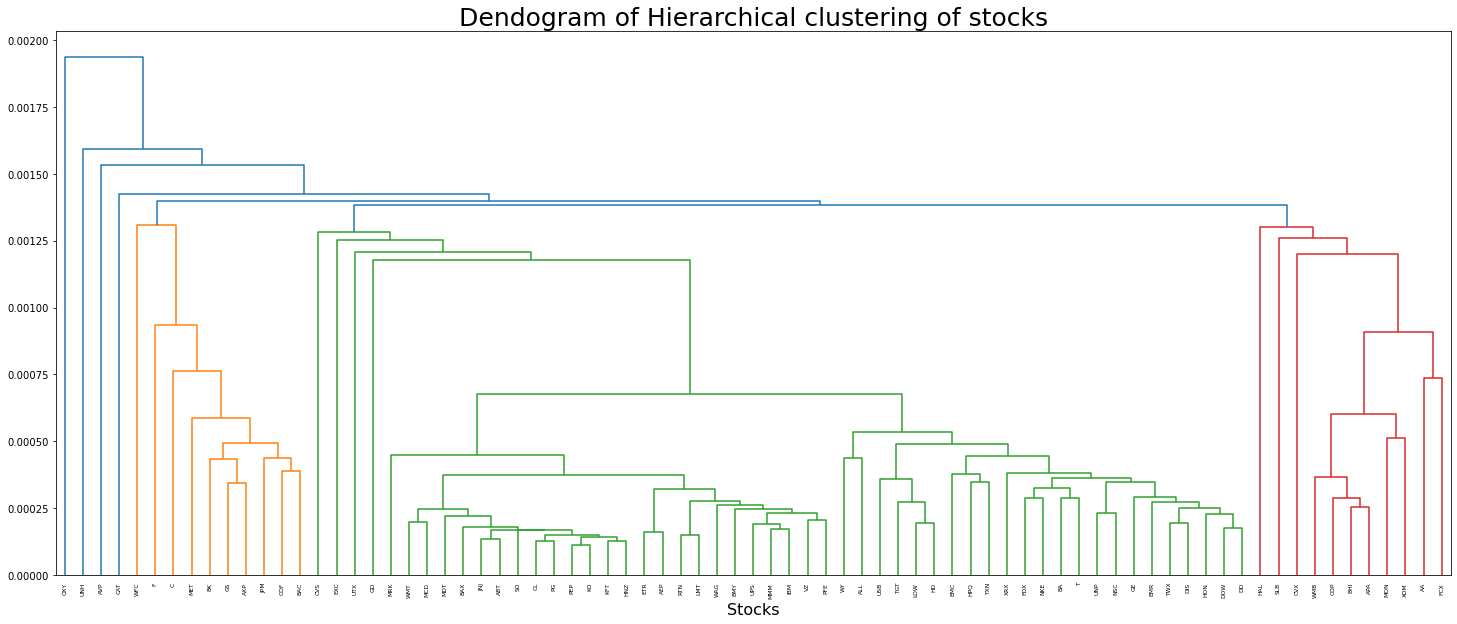

In [264]:
Z = linkage(covariance, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z,labels=list(covariance.columns))

plt.title("Dendogram of Hierarchical clustering of stocks",fontsize=25)
plt.xlabel("Stocks",fontsize=16)
plt.show()

In [265]:
cov=covariance.copy()
ordered_stocks = [list(cov.columns)[i] for i in leaves_list(Z)]
cov=cov[ordered_stocks]
cov=cov.reindex(cov.columns)

Text(105.0, 0.5, 'Stocks')

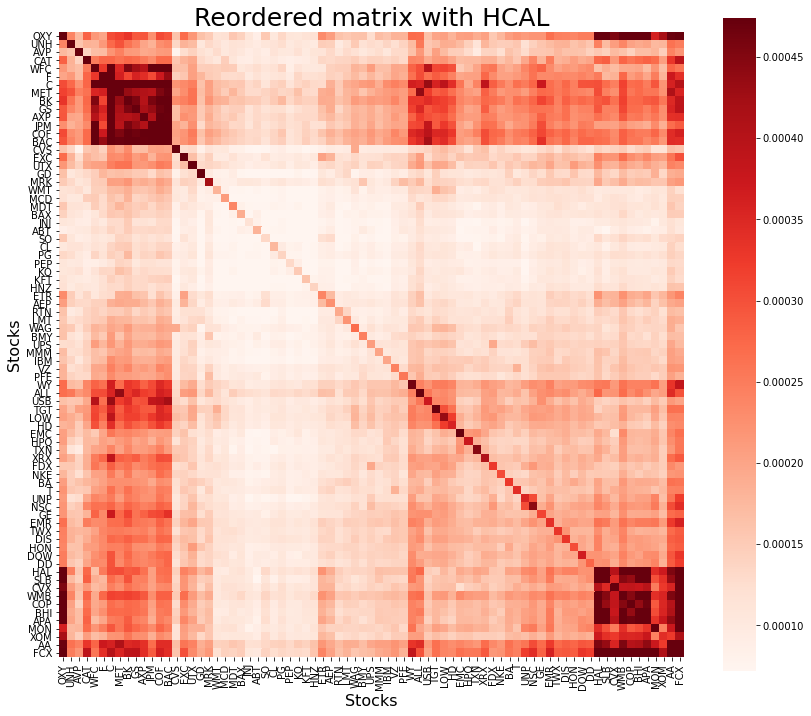

In [266]:
fig ,ax = plt.subplots(figsize=(14,12))
sns.heatmap(cov,xticklabels=True, yticklabels=True,robust=True,square=True,cmap="Reds")
plt.title("Reordered matrix with HCAL",fontsize=25)
plt.xlabel("Stocks",fontsize=16)
plt.ylabel("Stocks",fontsize=16)

In [294]:
preds_unfiltered=compute_mean_variance(filtered=False,window=90)
preds_unfiltered.columns=["Mean Variance unfiltered 90"]
preds_unfiltered

,Mean Variance unfiltered 90
xltime,
2004-01-05,0.000000
2004-01-06,0.000000
2004-01-07,0.000000
2004-01-08,0.000000
2004-01-09,0.000000
...,...
2008-12-24,0.013597
2008-12-26,-0.007529
2008-12-29,0.045695


In [295]:
portfolios=portfolios.merge(preds_unfiltered,how="left",left_index=True,right_index=True)
portfolios.fillna(method="ffill",inplace=True)
portfolios.fillna(method="bfill",inplace=True)

#### Filtered covariance with BAHC

In [270]:
filtered_cov=bahc.filterCovariance(np.array(returns).T,K=1)
filtered_cov=pd.DataFrame(filtered_cov)
filtered_cov.columns=returns.columns
filtered_cov.index=returns.columns
filtered_cov=filtered_cov[ordered_stocks]
filtered_cov=filtered_cov.reindex(filtered_cov.columns)

Text(105.0, 0.5, 'Stocks')

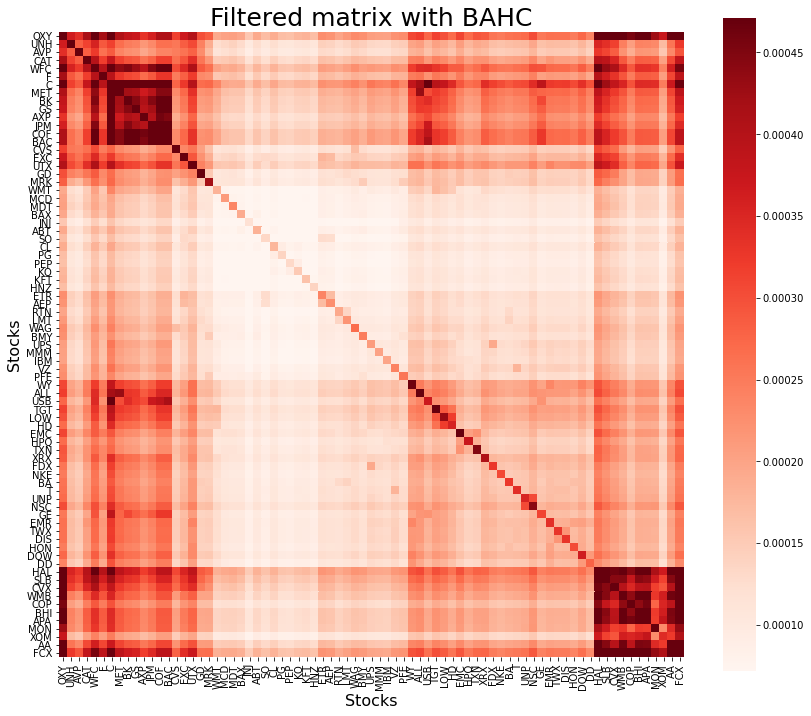

In [271]:
fig ,ax = plt.subplots(figsize=(14,12))
sns.heatmap(filtered_cov,xticklabels=True, yticklabels=True,robust=True,square=True,cmap="Reds",cbar=True)
plt.title("Filtered matrix with BAHC",fontsize=25)
plt.xlabel("Stocks",fontsize=16)
plt.ylabel("Stocks",fontsize=16)

In [296]:
preds=compute_mean_variance(filtered=True,window=90)
preds.columns=["Mean Variance with BAHC 90"]
preds

,Mean Variance with BAHC 90
xltime,
2004-01-05,0.000000
2004-01-06,0.000000
2004-01-07,0.000000
2004-01-08,0.000000
2004-01-09,0.000000
...,...
2008-12-24,0.005662
2008-12-26,-0.004912
2008-12-29,-0.004252


In [297]:
portfolios=portfolios.merge(preds,how="left",left_index=True,right_index=True)
portfolios.fillna(method="ffill",inplace=True)
portfolios.fillna(method="bfill",inplace=True)

### Mean reversion strategy 

#### Hurst exponent

A time series can then be characterised in the following manner:

- H<0.5H<0.5 : The time series is mean reverting
- H=0.5H=0.5 : The time series is a Geometric Brownian Motion
- H>0.5H<1 :   The time series is trending

In addition to characterisation of the time series the Hurst Exponent also describes the extent to which a series behaves in the manner categorised. For instance, a value of HH near 0 is a highly mean reverting series, while for HH near 1 the series is strongly trending

In [152]:
hurst_coef = {}
hurst_list = []
for i,e in enumerate(df_day_opening):
    tmp = hurst(np.log(df_day_opening.iloc[:,i].values))
    hurst_coef[e] = tmp
    hurst_list.append(tmp)
    print('Hurst exponent of '+ e +' is {:.2f}'.format(tmp))

Hurst exponent of DOW is 0.49
Hurst exponent of PEP is 0.47
Hurst exponent of CVS is 0.47
Hurst exponent of UNH is 0.48
Hurst exponent of CL is 0.44
Hurst exponent of DD is 0.54
Hurst exponent of EXC is 0.49
Hurst exponent of SLB is 0.55
Hurst exponent of FDX is 0.44
Hurst exponent of AA is 0.57
Hurst exponent of NKE is 0.40
Hurst exponent of JNJ is 0.45
Hurst exponent of VZ is 0.42
Hurst exponent of BAX is 0.43
Hurst exponent of GD is 0.54
Hurst exponent of WMT is 0.39
Hurst exponent of RTN is 0.44
Hurst exponent of WY is 0.43
Hurst exponent of LMT is 0.51
Hurst exponent of BHI is 0.58
Hurst exponent of WMB is 0.49
Hurst exponent of MCD is 0.42
Hurst exponent of MDT is 0.49
Hurst exponent of KFT is 0.40
Hurst exponent of BMY is 0.42
Hurst exponent of ETR is 0.53
Hurst exponent of GE is 0.50
Hurst exponent of COF is 0.39
Hurst exponent of OXY is 0.43
Hurst exponent of ALL is 0.44
Hurst exponent of BA is 0.50
Hurst exponent of T is 0.50
Hurst exponent of ABT is 0.40
Hurst exponent of F 

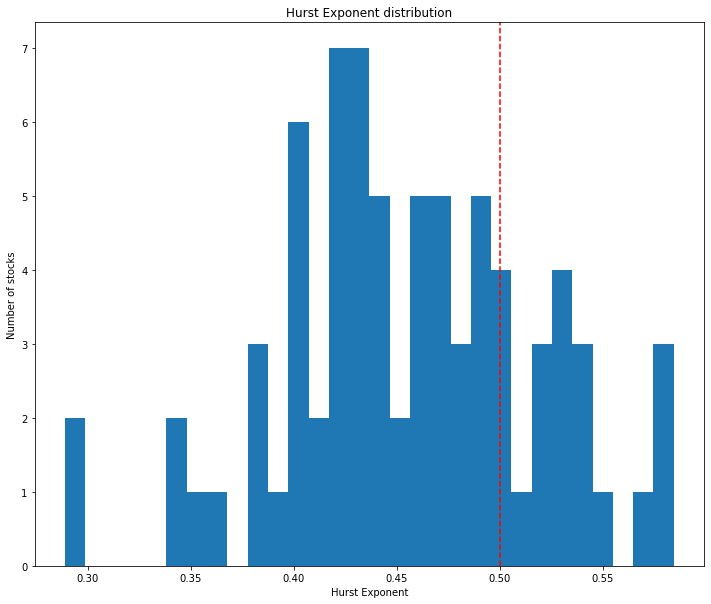

In [153]:

fig, ax = plt.subplots(figsize = (12,10))

ax.set_title("Hurst Exponent distribution")
ax.set_xlabel("Hurst Exponent")
ax.set_ylabel("Number of stocks")
N, bins, patches = ax.hist(hurst_list, bins=30)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.show()

In [154]:
hurst_list = np.array(hurst_list)

In [155]:
sum(hurst_list < 0.5 )

60

We have 60 stocks than are mean reverting. 

### Pair trading

We need find to  two assets, such that their linear combination is stationary.

The two time series $X_t$, $Y_t$ are cointegrated if there exists a $\beta$ such that $X_t = \beta Y_t + e_t$ and  $e_t$ is stationary.

We first estimate $e_t$ using and ordinary least square regression and then we run an Augmented Dickey Fueller test to check its stationarity. 

In [159]:
pvalue_matrix = cointegration_pvalue_marix(df_day_opening)

CVS and PEP are cointegrated
EXC and CVS are cointegrated
SLB and PEP are cointegrated
SLB and CVS are cointegrated
BAX and NKE are cointegrated
GD and PEP are cointegrated
GD and CVS are cointegrated
GD and EXC are cointegrated
GD and SLB are cointegrated
WMT and UNH are cointegrated
WMT and FDX are cointegrated
RTN and NKE are cointegrated
LMT and RTN are cointegrated
WMB and PEP are cointegrated
WMB and CVS are cointegrated
WMB and EXC are cointegrated
WMB and GD are cointegrated
MDT and DOW are cointegrated
KFT and DOW are cointegrated
KFT and DD are cointegrated
KFT and FDX are cointegrated
KFT and AA are cointegrated
KFT and VZ are cointegrated
KFT and WY are cointegrated
BMY and VZ are cointegrated
ETR and NKE are cointegrated
ETR and RTN are cointegrated
ETR and LMT are cointegrated
GE and WY are cointegrated
OXY and NKE are cointegrated
OXY and BAX are cointegrated
ABT and CL are cointegrated
ABT and NKE are cointegrated
ABT and BAX are cointegrated
ABT and RTN are cointegrate

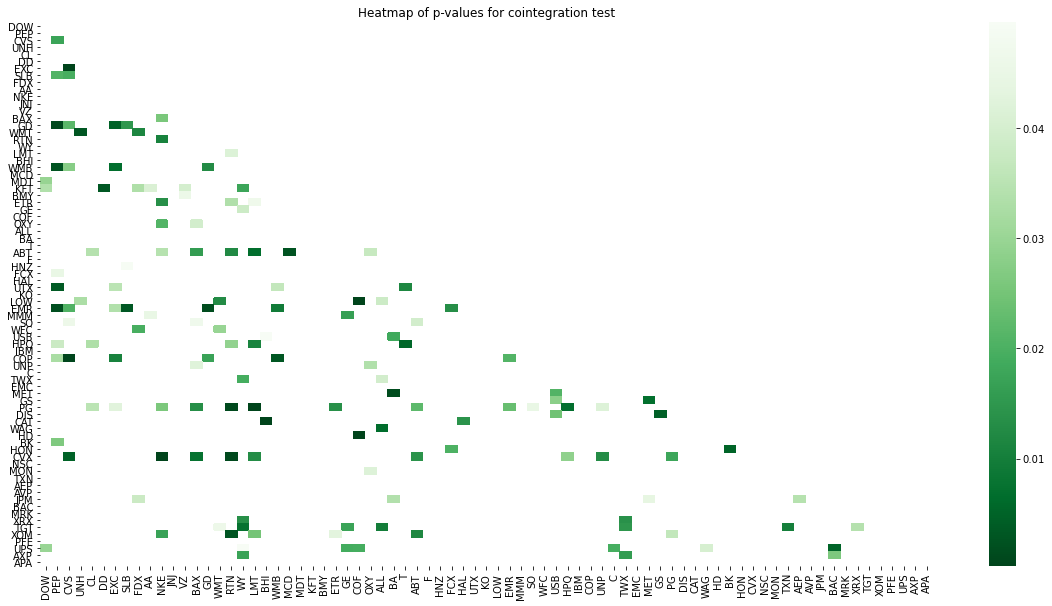

In [162]:
plot_heatmap(df_day_opening, pvalue_matrix)

### Implementation of the strategy/ backtesting window rolling

In [175]:
# Parameters to tune
data = df_day_opening.copy()
window_estimate = 90 
window_backtest = 90 

In [322]:
def backtesting(data ,window_estimate = 90, window_backtest = 90, plot = False ):
    money_per_period = {}
    
    for i in range(0, len(data) - (window_estimate + window_backtest), window_estimate):
        moneys = []
        data_estimate = data[i:i+window_estimate]
        data_backtest = data[i+window_estimate:i+window_estimate+window_backtest]

        #Estimate the cointegration pairs and their hedge ratio
        cointegrated_stocks, spread_means, spread_stds, alphas, hedge_ratios = estimation_phase(data_estimate)
        print('We have {:d} pairs of cointegrated stocks'.format(len(cointegrated_stocks)))

        #Backtesting
        for ((x_name,y_name), spread_mean, spread_std, alpha, h) in zip(cointegrated_stocks, spread_means, spread_stds, alphas, hedge_ratios):

            x = data_backtest.loc[:, x_name]
            y = data_backtest.loc[:, y_name]

            #compute the spread and hold position
            money = value_strategy(x, y, alpha, spread_mean, spread_std, h, plot = plot)

            moneys.append(money)

        np.sum(np.array(moneys) >= 0, axis=0)

        winning = np.sum(np.array(moneys) >= 0, axis=0)
        losing = np.sum(np.array(moneys) < 0, axis=0)

        total_money = sum(moneys)
        print('During period starting at '+ str(data_backtest.index[0]).split(' ')[0]+ ' earned {:.2f} $ with {:d} winning pairs and {:d} loosing pairs'.format(total_money, int(winning), int(losing)))
        money_per_period[data_backtest.index[0]] = total_money
    
    return money_per_period


money_per_period=backtesting(data)

We have 243 pairs of cointegrated stocks
During period starting at 2004-04-01 earned 18.94 $ with 138 winning pairs and 105 loosing pairs
We have 133 pairs of cointegrated stocks
During period starting at 2004-06-30 earned -25.45 $ with 60 winning pairs and 73 loosing pairs
We have 215 pairs of cointegrated stocks
During period starting at 2004-09-28 earned -60.78 $ with 99 winning pairs and 116 loosing pairs
We have 339 pairs of cointegrated stocks
During period starting at 2004-12-27 earned 33.35 $ with 191 winning pairs and 148 loosing pairs
We have 195 pairs of cointegrated stocks
During period starting at 2005-03-27 earned -55.22 $ with 94 winning pairs and 101 loosing pairs
We have 150 pairs of cointegrated stocks
During period starting at 2005-06-25 earned -72.48 $ with 64 winning pairs and 86 loosing pairs
We have 210 pairs of cointegrated stocks
During period starting at 2005-09-23 earned 9.65 $ with 127 winning pairs and 83 loosing pairs
We have 217 pairs of cointegrated stoc

We have 0 pairs of cointegrated stocks
During period 0 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 1 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 2 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 3 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 4 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 1 pairs of cointegrated stocks


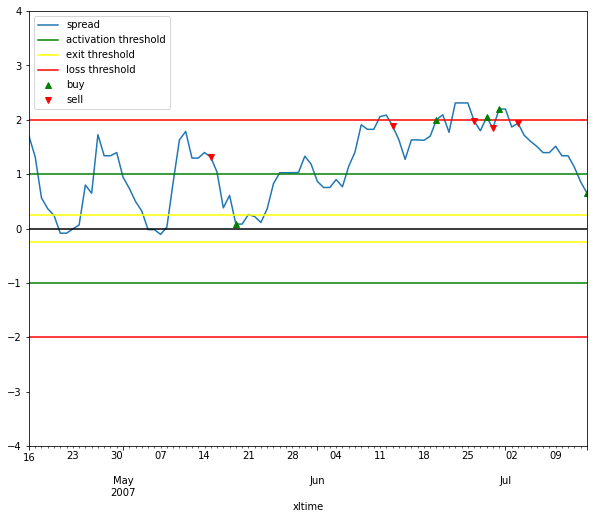

During period 5 earned 6.363571 $ with 1 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 6 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs
We have 0 pairs of cointegrated stocks
During period 7 earned 0.000000 $ with 0 winning pairs and 0 loosing pairs


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 6.363570854508609, 6: 0, 7: 0}

In [283]:

backtesting(df_day_opening[['CVS', 'PEP']], plot = True)

## Results

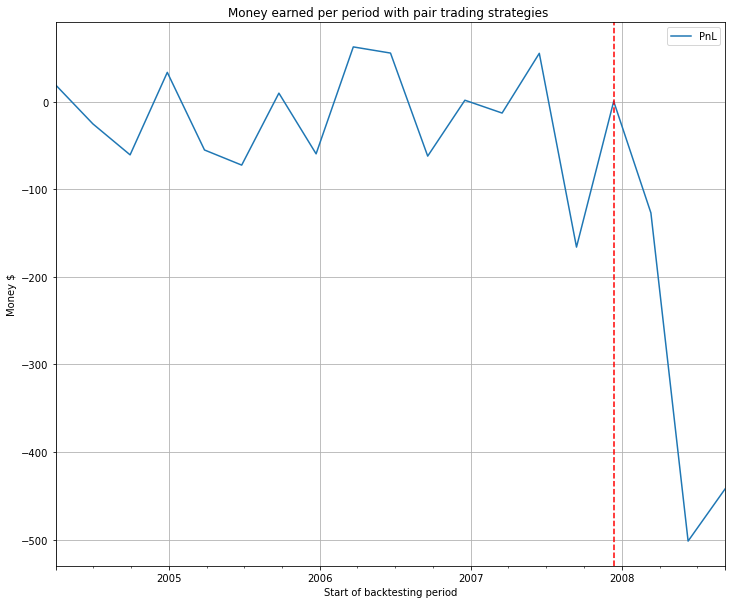

In [328]:
fig, ax = plt.subplots(figsize = (12,10))

ax.set_title("Money earned per period with pair trading strategies ")
ax.set_xlabel("Start of backtesting period")
ax.set_ylabel("Money $")
pd.DataFrame(data = list(money_per_period.values()), index = money_per_period.keys(),columns=["PnL"]).plot(ax =ax)
plt.axvline(x=list(money_per_period.keys())[15], color='red', linestyle='--')
plt.grid()
plt.legend()
plt.show()

Text(0, 0.5, 'Price in dollars')

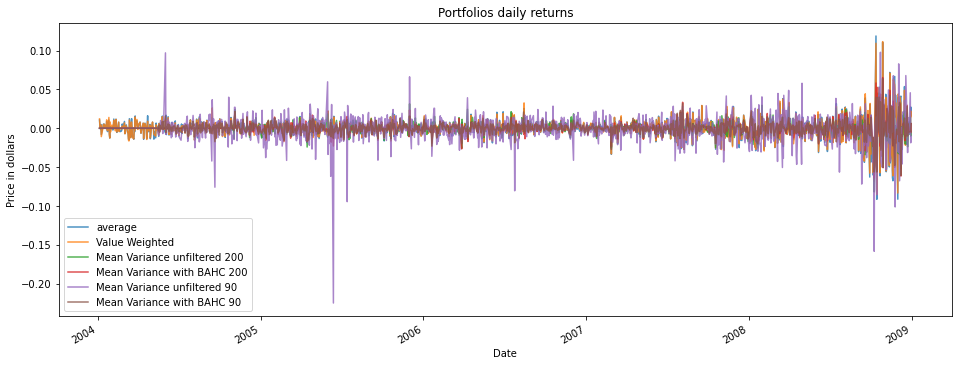

In [301]:
portfolios.plot(figsize=(16,6),alpha=0.8)
plt.title("Portfolios daily returns")
plt.xlabel("Date")
plt.ylabel("Price in dollars")

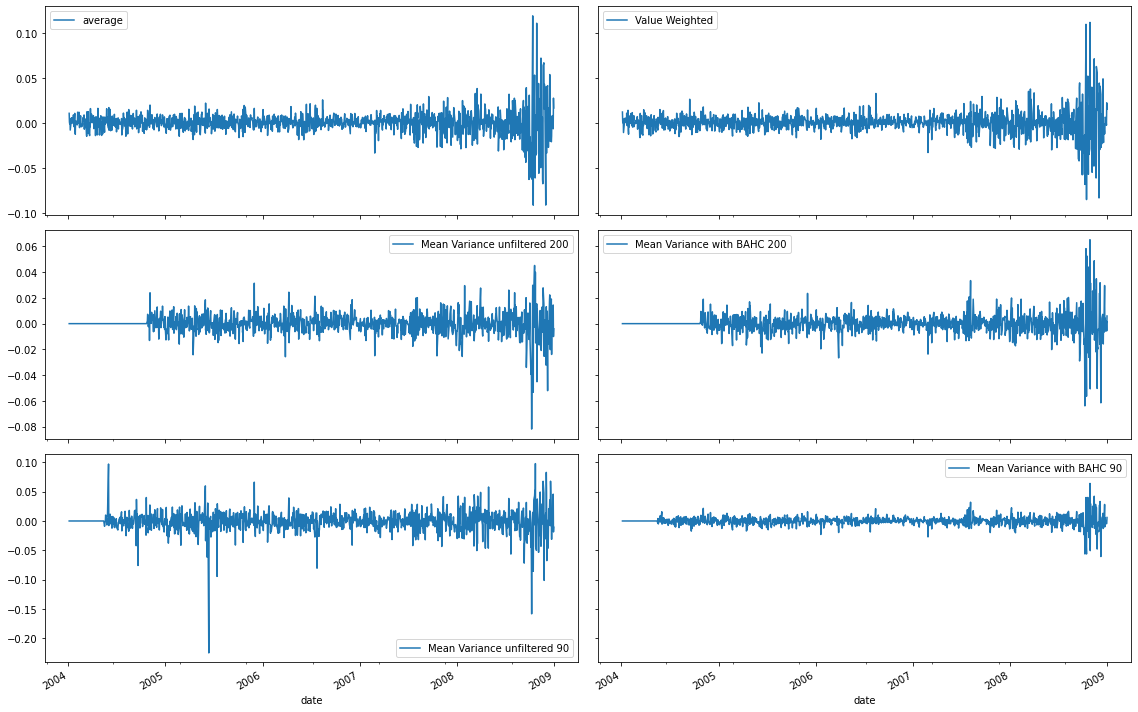

In [314]:
fig, axs = plt.subplots(figsize = (16,10), nrows = 3, ncols = 2,sharex='col', sharey='row')
axs = axs.flatten()
for (i,col) in enumerate(portfolios.columns):
    portfolios[col].plot(label=col, legend=True, ax = axs[i])
    axs[i].set_xlabel("date")

plt.tight_layout()
plt.show()

In [315]:
# Let's how our strategies perform if we invest $1 in each one from the first day
port_value=portfolios.copy()
port_value.loc[BEGINNING]=[0]*port_value.shape[1]
port_value.sort_index(inplace=True)
port_value=port_value+1
port_value=port_value.apply(np.cumprod)
port_value

,average,Value Weighted,Mean Variance unfiltered 200,Mean Variance with BAHC 200,Mean Variance unfiltered 90,Mean Variance with BAHC 90
xltime,,,,,,
2004-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2004-01-05 00:00:00,1.010592,1.012037,1.000000,1.000000,1.000000,1.000000
2004-01-06 00:00:00,1.011473,1.013530,1.000000,1.000000,1.000000,1.000000
2004-01-07 00:00:00,1.010434,1.013493,1.000000,1.000000,1.000000,1.000000
2004-01-08 00:00:00,1.015381,1.017819,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
2008-12-24 00:00:00,1.133318,1.225552,0.989628,0.922678,0.297416,0.847445
2008-12-26 00:00:00,1.142412,1.232253,0.981855,0.917367,0.295177,0.843282
2008-12-29 00:00:00,1.134894,1.229034,0.996081,0.919161,0.308665,0.839697


Text(0, 0.5, 'Portfolio value in dollars')

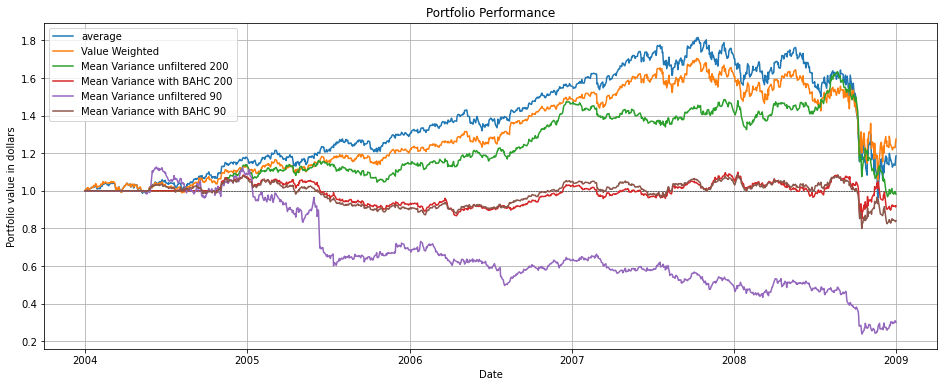

In [316]:
fig ,ax = plt.subplots(figsize=(16,6))
plt.plot(port_value)
plt.legend(port_value.columns)
plt.grid()
plt.hlines(y=1,xmin=BEGINNING,xmax=END,linestyles="--",linewidth=0.5)
plt.title("Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio value in dollars")